Winnie VORIHILALA <br />
MS ESD 2019-2020 <br />
INSA Rouen <br />

# <center> TP Deep Learning : Classification d'images </center>


L'obectif de ce TP consiste à catégoriser des images en 2 classes : chihuahua et muffin puis à prédire si de nouvelles images de test appartiennent à la classe "chihuahua" ou à la classe "muffin". Pour cela, nous allons tester 3 méthodes :
- la première consiste à entrainer notre propre modèle puis à effectuer notre prédiction à partir de ce modèle entrainé
- la 2ème consiste à utiliser la méthode bottleneck information à partir d'un modèle déjà entrainé
- la 3ème consiste à faire du fine-tuning à partir d'un modèle déjà entrainé.
<br />
 
Nous allons comparer les résultats obtenus par ces 3 méthodes et déterminer laquelle permet d'obtenir le meilleur score.

In [4]:
#Connexion à mon drive où sont stockés les dataset
from google.colab import drive
drive.mount("/content/gdrive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Afin que l'environnement d'execution soit bien GPU, aller dans Execution/Modifier le type d'exécution/Selectionner GPU dans Accélérateur matériel.
Il est nécessaire d'effectuer cette manipulation car certaines méthodes qui seront vues dans ce TP, notamment le fine tuning nécessite beaucoup de puissance de calcul

In [5]:
#Verification de l'environnement d'execution
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
#Affichage des caractéristiques de l'environnement d'execution
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13225105667527374180, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5891333312128475090
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2747281181241933172
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7470045594
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10854433744829599404
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

In [7]:
#Vérification de la version de tensorflow
%tensorflow_version
#%tensorflow_version 1.x : pour selectionner la v1 de tensorflow


Currently selected TF version: 1.x
Available versions:
* 1.x
* 2.x


In [8]:
!nvidia-smi

Wed Feb 26 17:59:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    24W /  75W |    333MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt

In [0]:
# Chargement des dataset depuis mon drive
train_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/test'
#print(type(train_data_dir))

# 1ère méthode : convolutional neural network with original dataset

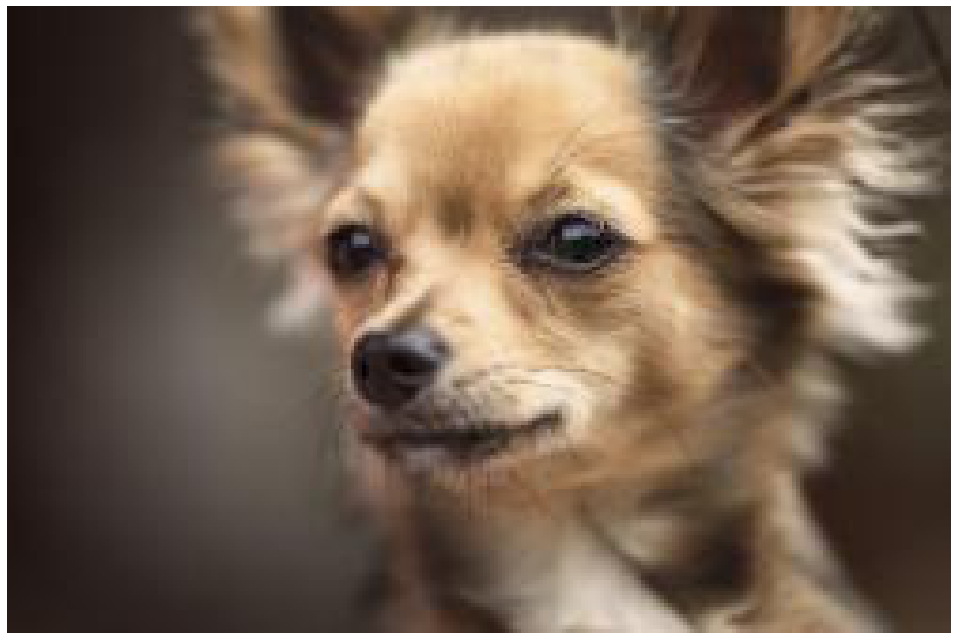

In [13]:
#Test de lecture d'une image quelconque pour vérifier que nos dataset ont bien été chargés 
im = plt.imread('gdrive/My Drive/Data/chihuahua-vs-muffin/train/chihuahua/ActiOn_1.jpg')

plt.figure(figsize=(15,9))
plt.imshow(im)
plt.axis('off')
plt.tight_layout()

In [0]:
#Initialisation du nombre d'itérations (epochs) et du nombre de lots par itération (batch_size)
epochs = 50 #initialement à 5, attention ne pas prendre trop petit car ralentit le temps d'execution 
batch_size = 32 #initialement à 16, attention ne pas prendre trop petit car ralentit le temps d'execution

In [94]:
#Configuration de l'augmentation des données que l'on utilisera lors de notre apprentissage

#Ce procédé est utile lorsqu'on a peu de données d'apprentissage.
#ImageDataGenerator permet d'augmenter en temps réel les données d'apprentissage en générant des images artificielles 
#chacune différente les unes des autres grace au réglages des différentes paramètres de la fonction

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, #la division par 255 permet de normaliser les photos
    #shear_range=0.2, #intensité de cisaillement (angle de cisaillement dans le sens antihoraire en degrés)
    shear_range=50,
    zoom_range=0.2, #plage de zoom aléatoire
    horizontal_flip=True, #retourne aléatoirement les entrées verticalement
    #vertical_flip=True #retourne aléatoirement les entrées verticalement
    )

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# dimensions of our images.
img_width, img_height = 256,256

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Nos données d'apprentissage se composent de 568 images appartenant aux 2 classes chihuahua et muffin. <br>
Nos données de validation se composent de 141 images appartenant aux 2 classes chihuahua et muffin. <br>

In [0]:
image_batch, label_batch = next(train_generator)

In [0]:
#Fonction qui permet la visualisation d'un extrait de notre training set incluant les images générées artificiellement avec ImageGenerator()
CLASS_NAMES = list(train_generator.class_indices.keys())
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n].argmax()].title())
      plt.axis('off')

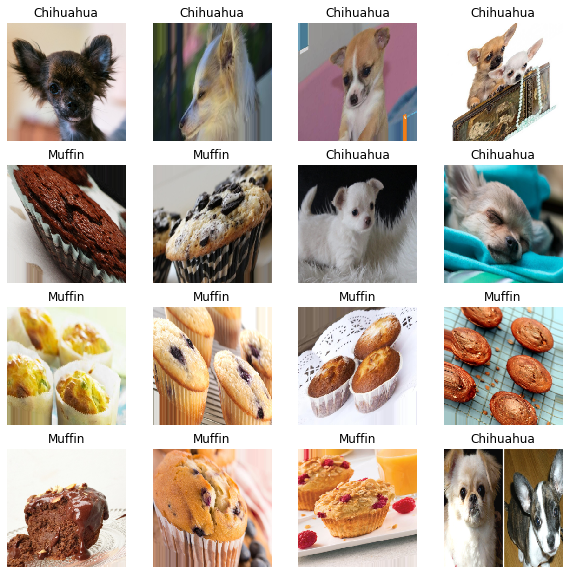

In [97]:
show_batch(image_batch, label_batch)

Les images distordues ci-dessus sont les images qui ont été générées artificiellement avec la fonction ImageGenerator.

In [0]:
nb_train_samples = train_generator.n
nb_validation_samples = validation_generator.n
nb_test_samples = test_generator.n

In [0]:
#Creation du modèle de réseau de neurones 

input_shape = (img_height, img_width, 3) #3 car les images sont en couleur
model = Sequential() 
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) #permet de mettre les images bout à bout
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.1)) #10% des neurones seront ignorées

model.add(Dense(2)) #2 car nos avons 2 classes : chihuahua et muffin
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam', 
              metrics=['accuracy'])

In [100]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 32)       

In [102]:
model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/50
17/17 - 18s - loss: 0.0451 - acc: 0.9851 - val_loss: 0.2658 - val_acc: 0.9297
Epoch 2/50
Epoch 1/50
17/17 - 18s - loss: 0.0610 - acc: 0.9832 - val_loss: 0.2076 - val_acc: 0.9453
Epoch 3/50
Epoch 1/50
17/17 - 17s - loss: 0.0398 - acc: 0.9869 - val_loss: 0.2755 - val_acc: 0.9219
Epoch 4/50
Epoch 1/50
17/17 - 17s - loss: 0.0436 - acc: 0.9832 - val_loss: 0.2141 - val_acc: 0.9453
Epoch 5/50
Epoch 1/50
17/17 - 17s - loss: 0.0419 - acc: 0.9907 - val_loss: 0.2900 - val_acc: 0.9219
Epoch 6/50
Epoch 1/50
17/17 - 17s - loss: 0.0536 - acc: 0.9832 - val_loss: 0.2570 - val_acc: 0.9297
Epoch 7/50
Epoch 1/50
17/17 - 17s - loss: 0.0738 - acc: 0.9757 - val_loss: 0.2549 - val_acc: 0.9219
Epoch 8/50
Epoch 1/50
17/17 - 17s - loss: 0.0674 - acc: 0.9720 - val_loss: 0.2278 - val_acc: 0.9375
Epoch 9/50
Epoch 1/50
17/17 - 17s - loss: 0.0579 - acc: 0.9779 - val_loss: 0.2817 - val_acc: 0.9297
Epoch 10/50
Epoch 1/50
17/17 - 17s - loss: 0.0335 - acc: 0.9869 - val_loss: 0.2296 - val_acc: 0.9375
Epoch 11/5

In [103]:
model.evaluate(train_generator)

 2/18 [==>...........................] - ETA: 13s - loss: 0.0018 - acc: 1.0000

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 4/18 [=====>........................] - ETA: 11s - loss: 0.0012 - acc: 1.0000

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


18/18 [==============================] - 16s 877ms/step - loss: 0.0102 - acc: 0.9930


[0.010165814186620992, 0.9929578]

In [105]:
model.evaluate(validation_generator)

5/5 [==============================] - 3s 623ms/step - loss: 0.7127 - acc: 0.9149


[0.7127234458923339, 0.9148936]

In [107]:
model.evaluate(test_generator)

1/1 [==============================] - 0s 81ms/step - loss: 1.7230 - acc: 0.6250


[1.7230380773544312, 0.625]

Cette méthode nous donne une accuracy score de :
- 99,29% sur les données d'apprentissage
- 91,49% sur les données de validation
- 62,50% sur les données de test.

Nous obtenons des taux satisfaisants dans l'ensemble sur les données dapprentissage et de validation.

En revanche nous obtenons un très mauvais taux de bonne prédiction sur les données de test (62,50%). 

In [0]:
def predict_image(img_path): #fonction qui télécharge une image, la normalise et prédit si elle 
#appartient à la classe chihuahua ou à la classe muffin
    img = load_img(img_path,target_size=(img_height, img_width))
    x = img_to_array(img)
    x = x/255
    x = x.reshape((1,) + x.shape)
    plt.imshow(img)
    print([name for name, age in train_generator.class_indices.items() if age == model.predict_classes(x)[0]][0])

chihuahua


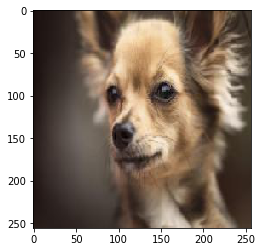

In [109]:
#test sur une image de notra training set
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/train/chihuahua/ActiOn_1.jpg') 

muffin


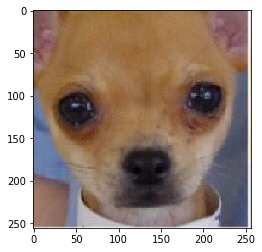

In [110]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/chihuahua/image1.jpg')

muffin


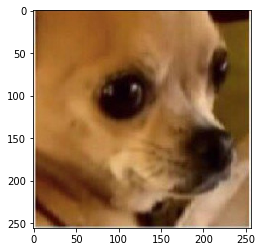

In [111]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/chihuahua/image2.jpg')

chihuahua


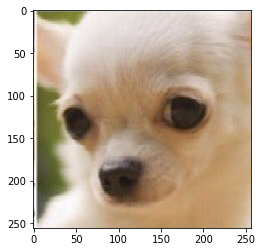

In [112]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/chihuahua/image3.jpg')

chihuahua


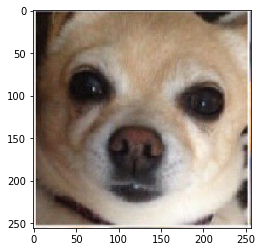

In [113]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/chihuahua/image4.jpg')

chihuahua


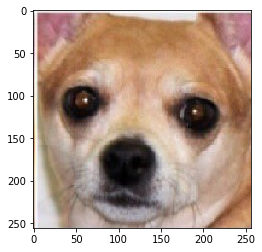

In [114]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/chihuahua/image5.jpg')

chihuahua


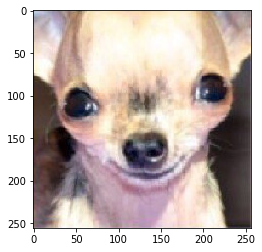

In [115]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/chihuahua/image6.jpg')

muffin


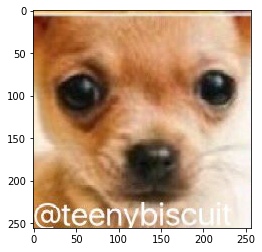

In [116]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/chihuahua/image7.jpg')

chihuahua


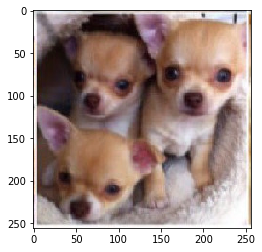

In [117]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/chihuahua/image8.jpg')

muffin


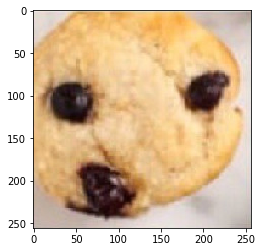

In [118]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/muffin/image9.jpg')

chihuahua


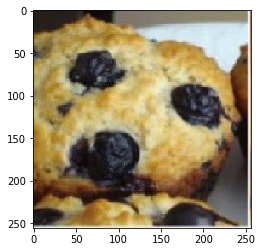

In [119]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/muffin/image10.jpg')

muffin


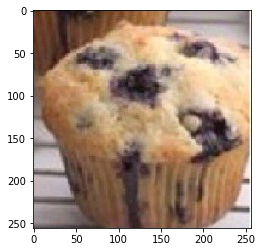

In [120]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/muffin/image11.jpg')

chihuahua


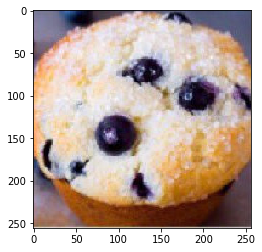

In [121]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/muffin/image12.jpg')

muffin


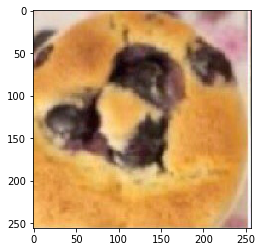

In [122]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/muffin/image13.jpg')

chihuahua


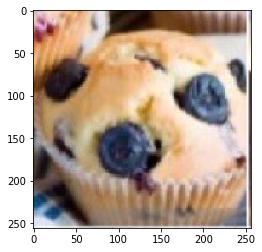

In [123]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/muffin/image14.jpg')

muffin


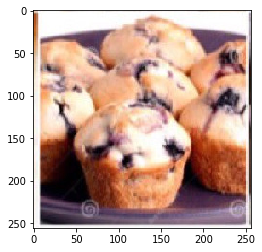

In [124]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/muffin/image15.jpg')

muffin


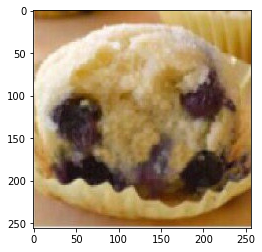

In [125]:
predict_image('gdrive/My Drive/Data/chihuahua-vs-muffin/test/muffin/image16.jpg')

L'utilisation de la fonction predict_image() sur les jeux de données de test confirme le résultat obtenus ci-dessus. En effet, la fonction donne des résultats pas du tout satisfaisants sur nos données de test (prédictions justes : 10/16, soit 62,5%, ce qui correspond exactement à l'accuracy score). Testons maintenant la 2ème méthode qui consiste à utiliser un jeu de données d'apprentissage déjà entrainé (transfert learning). 

# 2ème méthode : Méthode Bottleneck Information



Selon l'inventeur de cette méthode, Naftali Tishby (méthode également appelée principe du goulot d'étrangelement de l'information), les réseaux de neurones profonds sont capables d'apprendre grâce à l'information bottleneck. <br>

Un réseau traite les multiples données d’entrée renfermant de très nombreux détails en extrayant l’information comme s’il les faisait passer par un goulot de bouteille. Ainsi, il ne retient que les informations les plus importantes en fonction des concepts généraux. <br>

Cette méthode est conçue pour trouver le meilleur compromis entre précision et complexité ( compression ) lors de la synthèse (par exemple, en clustering ) d'une variable aléatoire X , étant donné une distribution de probabilité conjointe p (X, Y) entre X et une variable pertinente observée Y. <br>

Dans ce TP nous allons utiliser vgg16 (une version du réseau de neurones convolutif très connu appelé VGG-Net) fournie par Keras, qui a déjà été entrainé sur les 14 millions d'images présentes dans la base de données Imagenet, et qui permet de faire du transfert learning. <br>
<br>
<strong> Aparté : Qu'est ce que vgg16 et comment est constitué son architecture </strong> <br>
VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 couches fully-connected. Il doit donc apprendre les poids de 16 couches. <br>

Il prend en entrée une image en couleurs de taille 224  ×
 224 px et la classifie dans une des 1000 classes. Il renvoie donc un vecteur de taille 1000, qui contient les probabilités d'appartenance à chacune des classes. <br>

Chaque couche de convolution utilise des filtres en couleurs de taille 3  ×
3 px, déplacés avec un pas de 1 pixel. Le zero-padding vaut 1 pixel afin que les volumes en entrée aient les mêmes dimensions en sortie. Le nombre de filtres varie selon le "bloc" dans lequel la couche se trouve. De plus, un paramètre de biais est introduit dans le produit de convolution pour chaque filtre.

Chaque couche de convolution a pour fonction d'activation une ReLU. Autrement dit, il y a toujours une couche de correction ReLU après une couche de convolution.

L'opération de pooling est réalisée avec des cellules de taille 2 ×
 2 px et un pas de 2 px – les cellules ne se chevauchent donc pas.

Les deux premières couches fully-connected calculent chacune un vecteur de taille 4096, et sont chacune suivies d'une couche ReLU. La dernière renvoie le vecteur de probabilités de taille 1000 (le nombre de classes) en appliquant la fonction softmax. De plus, ces trois couches utilisent un paramètre de biais pour chaque élément du vecteur en sortie. <br>

Plus de détails : https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5097666-tp-implementez-votre-premier-reseau-de-neurones-avec-keras

<br> Pour récapituler, la méthode Bottleneck Information est une méthode de transfert learning qui consiste à utiliser le réseau de neurones comme une variable fixe d’extraction de caractéristiques et à l’appliquer telle quelle à notre dataset. Voici les étapes :

- On enlève la dernière couche, i.e. fully connected, du réseau,
- On « gèle » les poids du modèle et nous les utilisons comme une variable fixe d’extrait,
- On extrait alors les 4096 dimensionnels codes grâce à la variable fixée pour toutes les images,
- On entraîne une classification linéaire pour le nouveau dataset (e.g. SVM linéaire ou UMAP comme dans nore cas ci-dessous).

In [0]:
from tensorflow.keras import applications
#Les applications Keras sont des modèles d'apprentissage en profondeur qui sont mis à disposition avec 
#des poids pré-formés. Ces modèles peuvent être utilisés pour la prédiction, l'extraction de fonctionnalités 
#(exemple bottleneck information) et le réglage fin (fine tuning)
#Plus de détails : https://translate.google.com/translate?hl=fr&sl=en&u=http://keras.io/applications/&prev=search
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

In [127]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalMaxPooling2D
from keras import applications
from keras.applications.vgg16 import preprocess_input
# preprocess_imput : permet d'appliquer les mêmes pré-traitements que ceux utilisés sur l'ensemble d'apprentissage 
#lors du pré-entraînement. 

#from utils.canvas_embedding import *
from tensorflow.keras.utils import *

from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

In [148]:
%%time
img_width, img_height = 299,299
#Précision du répertoire où se trouvent nos dataset d'apprentissage, de test et de validation
train_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/test'

datagen = ImageDataGenerator()
generator_train = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=train_data_dir, class_mode='categorical')
generator_validation = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=validation_data_dir, class_mode='categorical')
generator_test = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=test_data_dir, class_mode='categorical')

Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
CPU times: user 30.2 ms, sys: 3.08 ms, total: 33.3 ms
Wall time: 314 ms


In [0]:
#création du mod§le VGG16
modelVGG16 = applications.VGG16(include_top=False, weights='imagenet', pooling='max')

In [150]:
#pre processing des training set
%%time
train_data = []
train_data_processed = []
train_target = []

for i in range(len(generator_train)):
    print(i)
    (data,target) = generator_train.next()
    train_data.append(data)
    train_data_processed.append(modelVGG16.predict(preprocess_input(data)))
    train_target.append(target)

0
1
2
3


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


4
5
6
7
8
9


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


10
11
12
13
14
15
16
17
CPU times: user 11.8 s, sys: 2.15 s, total: 14 s
Wall time: 14.1 s


In [151]:
#pre processing des validation set

%%time
validation_data = []
validation_data_processed = []
validation_target = []

for i in range(len(generator_validation)):
    print(i)
    (data,target) = generator_validation.next()
    validation_data.append(data)
    validation_data_processed.append(modelVGG16.predict(preprocess_input(data)))
    validation_target.append(target)

0
1
2
3
4
CPU times: user 3.9 s, sys: 605 ms, total: 4.51 s
Wall time: 4.57 s


In [152]:
#pre processing des test set

%%time
test_data = []
test_data_processed = []
test_target = []

for i in range(len(generator_test)):
    (data,target) = generator_test.next()
    test_data.append(data)
    test_data_processed.append(modelVGG16.predict(preprocess_input(data)))
    test_target.append(target)

CPU times: user 191 ms, sys: 65.6 ms, total: 257 ms
Wall time: 251 ms


In [153]:

import numpy as np

train_data = np.concatenate(train_data)
validation_data = np.concatenate(validation_data)
test_data = np.concatenate(test_data)


train_data_processed = np.concatenate(train_data_processed)
validation_data_processed = np.concatenate(validation_data_processed)
test_data_processed = np.concatenate(test_data_processed)


train_target = np.concatenate(train_target)
validation_target = np.concatenate(validation_target)
test_target = np.concatenate(test_target)


print(train_target.shape)
print(validation_target.shape)
print(test_target.shape)


(568, 2)
(141, 2)
(16, 2)


# SVC

In [155]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_target_sklearn = np.argmax(train_target,axis=1)
validation_target_sklearn = np.argmax(validation_target,axis=1)
test_target_sklearn = np.argmax(test_target,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed,train_target_sklearn)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [156]:
clf.score(train_data_processed,train_target_sklearn)

1.0

In [158]:
clf.score(validation_data_processed,validation_target_sklearn)

0.9858156028368794

In [157]:
clf.score(test_data_processed,test_target_sklearn)

0.875

En appliquant un algorithme de SVC sur nos données, après avoir utilisé un modèle VGG16, nous obtenons un taux de bonne prédiction de : 
- 100% sur les données d'apprentissage (ce qui est plus satisfaisant que les 99,29% obtenus en apprenant nous-même notre modèle) 
- 98,58% sur les données de validation (ce qui est plus satisfaisant que les 91,49% obtenus en apprenant nous-même notre modèle)
- 87,50% sur les données de test (ce qui est nettement plus satisfaisant que les 62,50% obtenus en apprenant nous-même notre modèle)

# UMAP

UMAP (Uniform Manifold Approximation and Projection) est une méthode de réduction des dimensions qui concurrence le t-SNE. L'UMAP est construit à partir d'un cadre théorique basé sur la géométrie riemannienne et la topologie algébrique. Le résultat est un algorithme évolutif pratique qui s'applique aux données du monde réel. L'algorithme UMAP est compétitif avec t-SNE pour la qualité de la visualisation et préserve sans doute une plus grande partie de la structure globale avec des performances d'exécution supérieures. En outre, UMAP n'a aucune restriction de calcul sur l'intégration de la dimension, ce qui la rend viable en tant que technique de réduction de dimension à usage général pour l'apprentissage automatique.

In [0]:
data = np.concatenate((train_data,validation_data))
data_processed = np.concatenate((train_data_processed,validation_data_processed))
targets_sklearn = np.concatenate((train_target_sklearn,validation_target_sklearn))

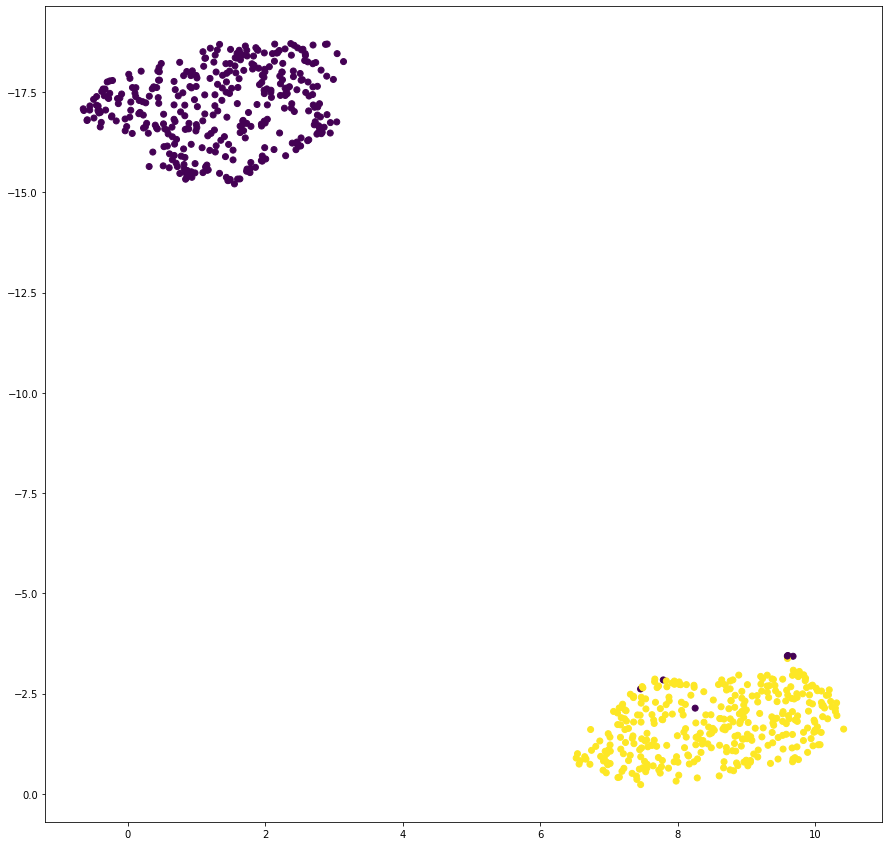

In [162]:
import umap
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csgraph

embedding = umap.UMAP()
data_umaped = embedding.fit_transform(data_processed)
plt.figure(figsize=(15,15))
plt.scatter(data_umaped[:,1],data_umaped[:,0],c=targets_sklearn)
plt.gca().invert_yaxis()

Nous pouvons constater avec le graphique ci-dessus que nos 2 classes sont effectivement bien distinctes et bien séparées, à l'exception de quelques petits points violets qui apparaissent dans la classe jaune. Ce résultat est cohérent avec les taux de bonne classification que nous avons obtenu ci-dessus avec le SVC.

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image as pil_image
import numpy as np
import matplotlib.pyplot as plt

def min_resize(img, size):
    w, h = map(float, img.shape[:2])
    if min([w, h]) != size:
        if w <= h:
            img = array_to_img(img).resize((int(round((h/w)*size)), int(size)),pil_image.NEAREST)
        else:
            img = array_to_img(img).resize((int(size), int(round((w/h)*size))),pil_image.NEAREST)
    return img_to_array(img)/255

def image_scatter(features_tsned, images, img_res, res=4000, cval=1.):
    images = [min_resize(image, img_res) for image in images]
    max_width = max([image.shape[0] for image in images])
    max_height = max([image.shape[1] for image in images])

    f2d = features_tsned

    xx = f2d[:, 0]
    yy = f2d[:, 1]
    x_min, x_max = xx.min(), xx.max()
    y_min, y_max = yy.min(), yy.max()
    # Fix the ratios
    sx = (x_max-x_min)
    sy = (y_max-y_min)
    if sx > sy:
        res_x = int(sx/float(sy)*res)
        res_y = res
    else:
        res_x = res
        res_y = int(sy/float(sx)*res)

    canvas = np.ones((res_x+max_width, res_y+max_height, 3))*cval
    x_coords = np.linspace(x_min, x_max, res_x)
    y_coords = np.linspace(y_min, y_max, res_y)
    for x, y, image in zip(xx, yy, images):
        w, h = image.shape[:2]
        x_idx = np.argmin((x_coords - x)**2)
        y_idx = np.argmin((y_coords - y)**2)
        canvas[x_idx:x_idx+w, y_idx:y_idx+h] = image
    return canvas

def save_embedding(canvas,filename,size):
    fig = plt.figure(figsize=(size,size))
    plt.imshow(canvas)
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(filename, bbox_inches = 'tight',pad_inches = 0)
    plt.close(fig)

def embedding(vis_data,ims,S,s):
    vis_data = vis_data - np.min(vis_data,0)
    data_norm = vis_data / np.max(vis_data,0)

    canvas = np.zeros((S,S, 3))
    i = 0
    for image in ims:
        a = np.ceil(data_norm[i] * (S-s)+1)[0]
        b = np.ceil(data_norm[i] * (S-s)+1)[1]
        aa = int(a-(((a-1) % s)+1))
        bb = int(b-(((b-1) % s)+1))
        if canvas[aa,bb,1] == 0:
            canvas[aa:aa+s, bb:bb+s] = min_resize(image, s)
        i+=1
    return canvas

def square_embedding(vis_data,ims,S,s):
    vis_data = vis_data - np.min(vis_data,0)
    data_norm = vis_data / np.max(vis_data,0)

    N = len(ims)
    canvas_square = np.zeros((S,S, 3))
    used = np.zeros(N,dtype=int)

    qq = len(np.arange(0,S,s))
    abes = np.zeros((qq*qq,2))
    i=0
    for a in np.arange(0,S,s):
        for b in np.arange(0,S,s):
            abes[i,:] = [a,b]
            i=i+1

    for i in range(abes.shape[0]):
        a = int(abes[i,0])
        b = int(abes[i,1])
        xf = (a-1)/S
        yf = (b-1)/S
        dd = np.sum(np.power(data_norm - np.array((xf,yf)),2),axis=1)
        dd[np.where(used == True)[0].tolist()] = float('Inf')
        di = np.argmin(dd)
        used[di] = True
        canvas_square[a:a+s, b:b+s] = min_resize(ims[di], s)
    return canvas_square

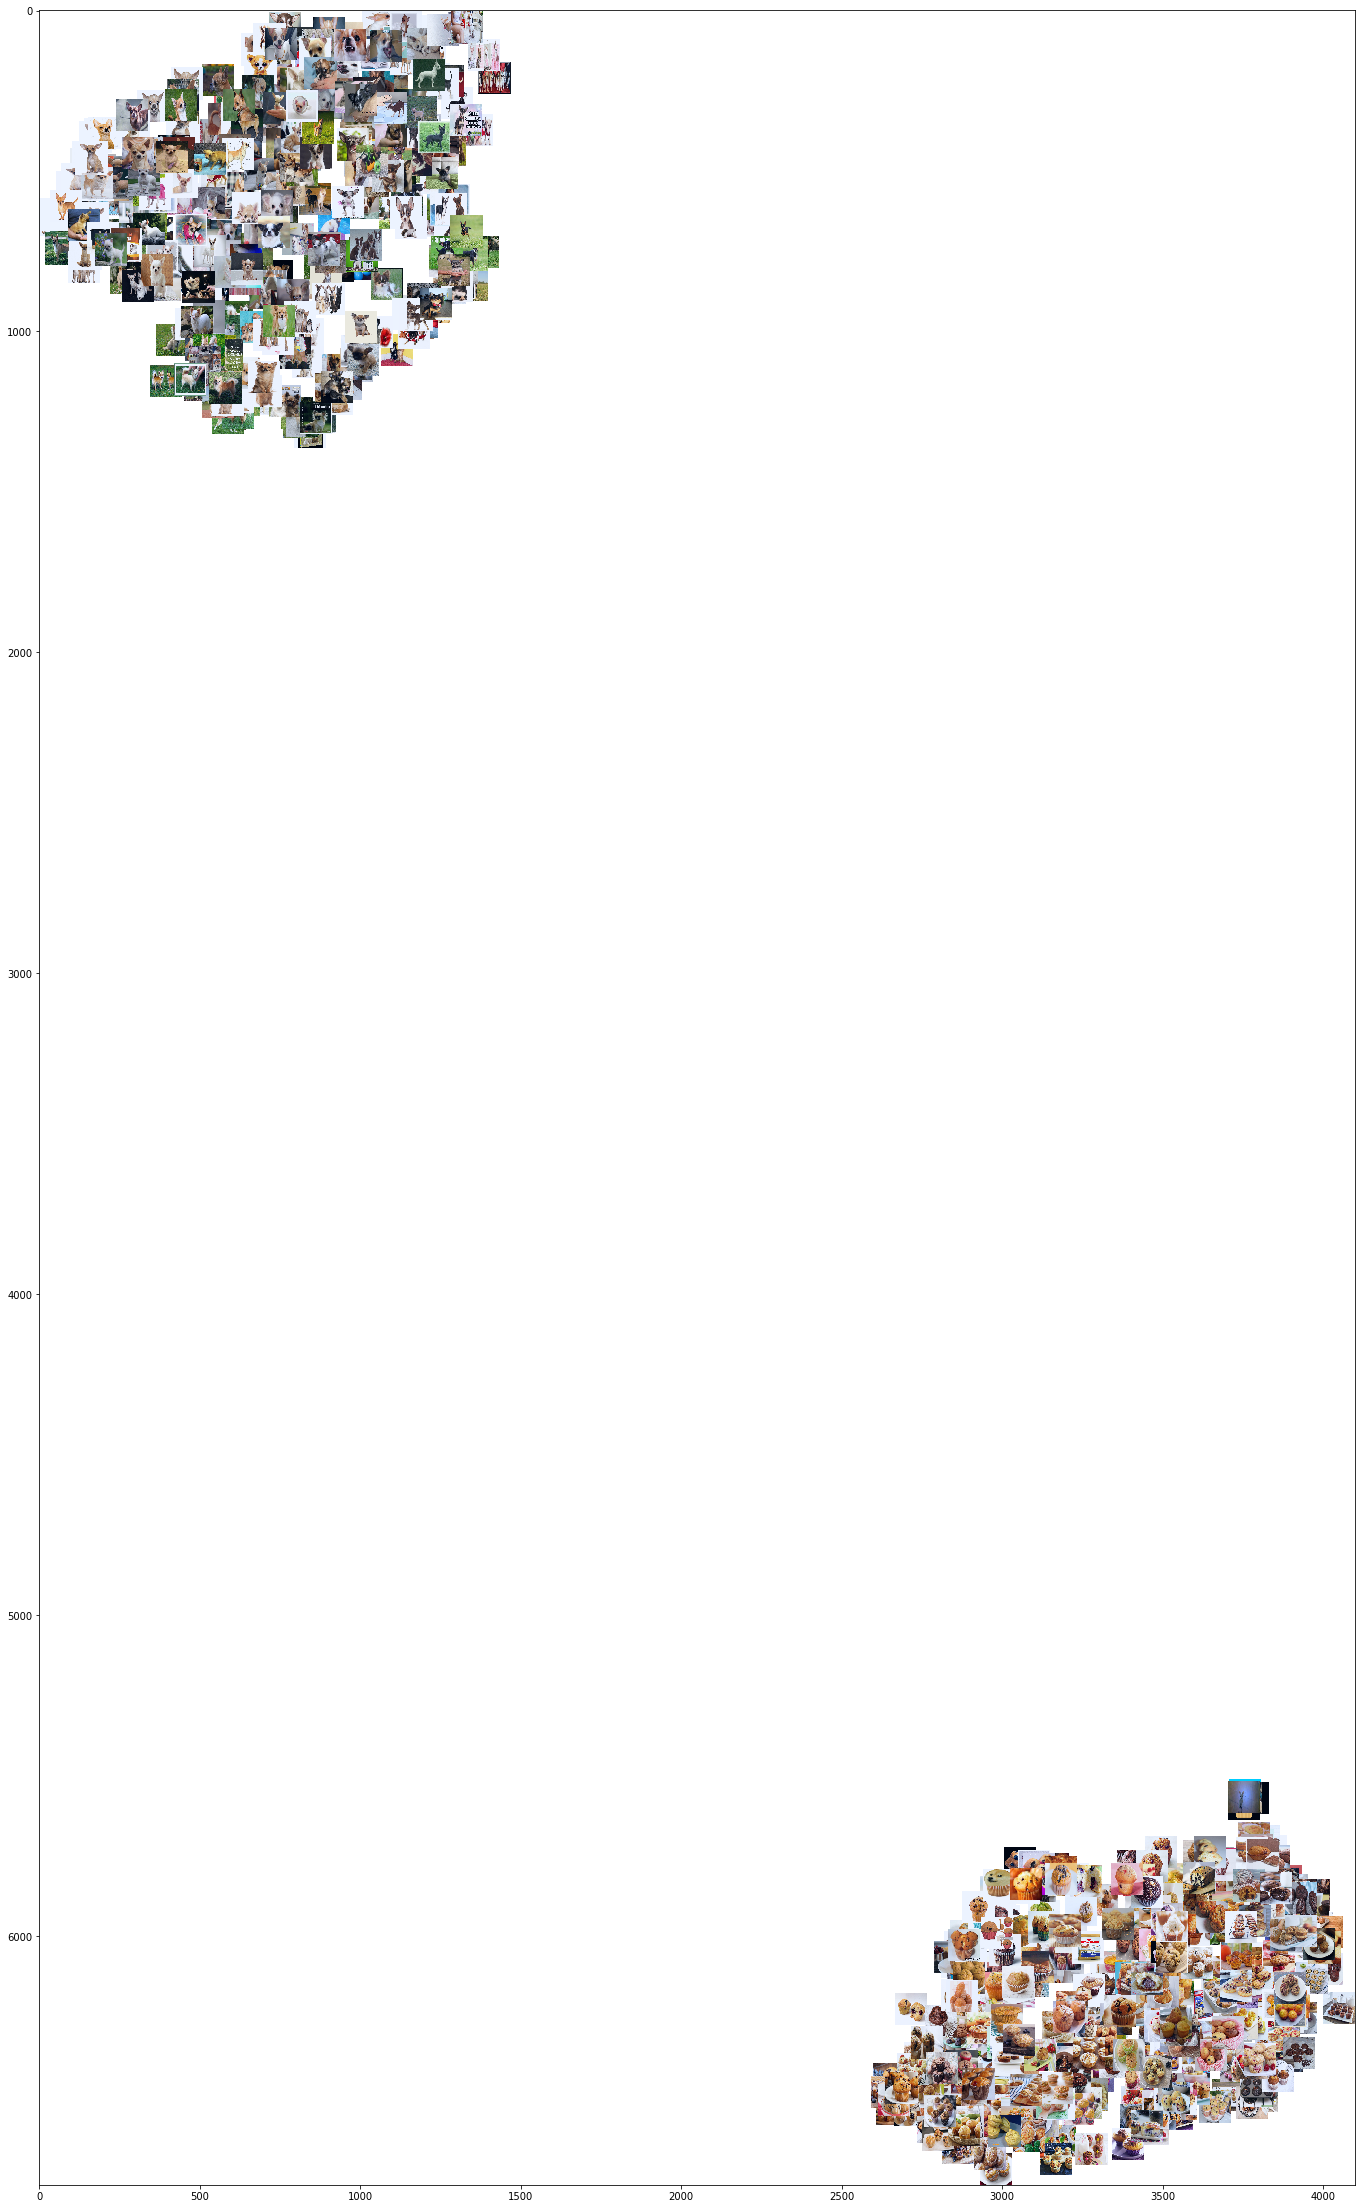

In [164]:
canvas_umap = image_scatter(data_umaped,data,100)
plt.figure(figsize=(40,40))
plt.imshow(canvas_umap)

In [0]:
import matplotlib.pyplot as plt
save_embedding(canvas_umap,'chihuahua_muffin.png',40)

VGG16 est un modèle de réseau de neurones convolutionnel proposé par K. Simonyan et A. Zisserman de l'Université d'Oxford dans l'article «Réseaux de convolution très profonds pour la reconnaissance d'images à grande échelle». Le modèle atteint une précision de test de 92,7% dans le top 5 dans ImageNet. VGG16 était l'un des célèbres modèles soumis à l' ILSVRC-2014. Ce modèle apporte une amélioration par rapport à AlexNet en remplaçant les grands filtres de taille de noyau (11 et 5 dans la première et la deuxième couche convolutionnelle respectivement) par plusieurs filtres de taille de noyau 3 × 3 l'un après l'autre. 
<br>
<br>
Cependant il existe d'autres modèles de réseaux de neurones qui ont succédé à VGG 16 (et qui sont disponibles dans Applications de Keras). A titre d'exemple, le modèle ResNet qui a remporté le défi d'ImageNet en 2015. La percée fondamentale avec ResNet a été de permettre de former avec succès des réseaux neuronaux extrêmement profonds avec plus de 150 couches. Avant la formation de ResNet, les réseaux neuronaux très profonds étaient difficiles à former en raison du problème de la disparition des gradients. 
<br>
<br>
Dans la suite de ce tp, pour cette 2ème méthode, nous allons tester différents types de modèles de réseaux de neurones tels que ResNet50, ResNet152, DenseNet, et nous comparerons les scores obtenus avec ceux obtenus en utilisant VGG16.

# Test avec ResNet 50

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import applications
from tensorflow.keras.applications.resnet import preprocess_input

import matplotlib.pyplot as plt

In [237]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalMaxPooling2D
from keras import applications
from keras.applications.resnet import preprocess_input
#from utils.canvas_embedding import *

from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

In [238]:
%%time
img_width, img_height = 299,299
#Précision du répertoire où se trouvent nos dataset d'apprentissage, de test et de validation
train_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/test'

datagen = ImageDataGenerator()
generator_train = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=train_data_dir, class_mode='categorical')
generator_validation = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=validation_data_dir, class_mode='categorical')
generator_test = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=test_data_dir, class_mode='categorical')

Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
CPU times: user 31.2 ms, sys: 10.3 ms, total: 41.4 ms
Wall time: 308 ms


In [0]:
#Création du modèle ResNet50
modelResNet50 = applications.resnet.ResNet50(include_top=False, weights='imagenet', pooling='max')


In [248]:
#Pre processing des données d'apprentissage, de validation et de test

%%time
train_data = []
train_data_processed = []
train_target = []

for i in range(len(generator_train)):
    print(i)
    (data,target) = generator_train.next()
    train_data.append(data)
    train_data_processed.append(modelResNet152.predict(preprocess_input(data)))
    train_target.append(target)

validation_data = []
validation_data_processed = []
validation_target = []

for i in range(len(generator_validation)):
    print(i)
    (data,target) = generator_validation.next()
    validation_data.append(data)
    validation_data_processed.append(modelResNet152.predict(preprocess_input(data)))
    validation_target.append(target)

test_data = []
test_data_processed = []
test_target = []

for i in range(len(generator_test)):
    (data,target) = generator_test.next()
    test_data.append(data)
    test_data_processed.append(modelResNet152.predict(preprocess_input(data)))
    test_target.append(target)


0
1
2
3


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


4
5
6
7
8
9


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


10
11
12
13
14
15
16
17
0
1
2
3
4
CPU times: user 19.6 s, sys: 5.38 s, total: 25 s
Wall time: 25.4 s


In [249]:
#Concaténation des données

import numpy as np

train_data = np.concatenate(train_data)
validation_data = np.concatenate(validation_data)
test_data = np.concatenate(test_data)


train_data_processed = np.concatenate(train_data_processed)
validation_data_processed = np.concatenate(validation_data_processed)
test_data_processed = np.concatenate(test_data_processed)


train_target = np.concatenate(train_target)
validation_target = np.concatenate(validation_target)
test_target = np.concatenate(test_target)


print(train_target.shape)
print(validation_target.shape)
print(test_target.shape)


(568, 2)
(141, 2)
(16, 2)


# SVC

In [250]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_target_sklearn_50 = np.argmax(train_target_50,axis=1)
validation_target_sklearn_50 = np.argmax(validation_target_50,axis=1)
test_target_sklearn_50 = np.argmax(test_target_50,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed,train_target_sklearn)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [252]:
clf.score(train_data_processed,train_target_sklearn)

1.0

In [253]:
clf.score(validation_data_processed,validation_target_sklearn)

0.9929078014184397

In [254]:
clf.score(test_data_processed,test_target_sklearn)

1.0

En appliquant un algorithme de SVC sur nos données, après avoir utilisé un modèle ResNet50, nous obtenons un taux de bonne prédiction de : 
- 100% sur les données d'apprentissage (même score qu'avec VGG16 et plus satisfaisant que les 99,29% obtenus en entrainant nous même notre propre modèle) 
- 99,29% sur les données de validation (ce qui est plus satisfaisant que les 98,58% obtenus avec VGG16 et les 91,49% obtenus en entrainant nous même notre propre modèle)
- 100% sur les données de test (ce qui est nettement plus satisfaisant que les 87,50% obtenus avec VGG16 et les 62,50% obtenus en entrainant nous même notre propre modèle)

# UMAP

In [0]:
data = np.concatenate((train_data,validation_data))
data_processed = np.concatenate((train_data_processed,validation_data_processed))
targets_sklearn = np.concatenate((train_target_sklearn,validation_target_sklearn))

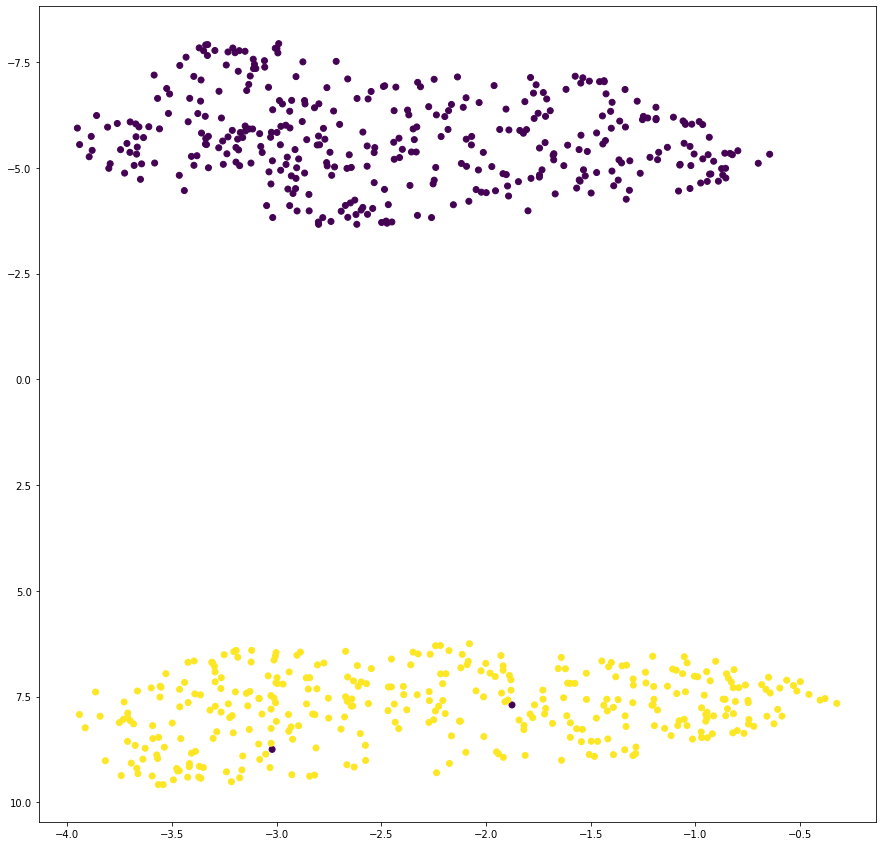

In [258]:
import umap
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csgraph

embedding = umap.UMAP()
data_umaped = embedding.fit_transform(data_processed)
plt.figure(figsize=(15,15))
plt.scatter(data_umaped[:,1],data_umaped[:,0],c=targets_sklearn)
plt.gca().invert_yaxis()

Nous pouvons constater avec ce graphique obtenu en utilisant la fonction UMAP que les 2 classes sont mieux séparés qu'avec VGG16, et qu'il n'y a que deux points violets dans la classe jaune, ce qui est cohérent avec le score obtenu avec SVC sur le dataset de validation (99%). 
<br>
Maintenant, testons le modèles ResNet152 qui comme son nom l'indique est un modèle de réseaux de neurones extrêmement profond constitué de 152 couches et comparons le score obtenu (qui devrait en principe être meilleur) avec ceux obtenus en utilisant VGG16 et ResNet50. 
<br>

# Test avec ResNet152

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import applications
from tensorflow.keras.applications.resnet import preprocess_input

import matplotlib.pyplot as plt

In [260]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalMaxPooling2D
from keras import applications
from keras.applications.resnet import preprocess_input
#from utils.canvas_embedding import *

from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

In [261]:
%%time
img_width, img_height = 299,299
#Précision du répertoire où se trouvent nos dataset d'apprentissage, de test et de validation
train_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/test'

datagen = ImageDataGenerator()
generator_train = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=train_data_dir, class_mode='categorical')
generator_validation = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=validation_data_dir, class_mode='categorical')
generator_test = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=test_data_dir, class_mode='categorical')

Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
CPU times: user 32.2 ms, sys: 10.2 ms, total: 42.4 ms
Wall time: 315 ms


In [0]:
#Création du modèle ResNet152
modelResNet152 = applications.resnet.ResNet152(include_top=False, weights='imagenet', pooling='max')


In [264]:
#Pre processing des données d'apprentissage, de validation et de test

%%time
train_data = []
train_data_processed = []
train_target = []

for i in range(len(generator_train)):
    print(i)
    (data,target) = generator_train.next()
    train_data.append(data)
    train_data_processed.append(modelResNet152.predict(preprocess_input(data)))
    train_target.append(target)

validation_data = []
validation_data_processed = []
validation_target = []

for i in range(len(generator_validation)):
    print(i)
    (data,target) = generator_validation.next()
    validation_data.append(data)
    validation_data_processed.append(modelResNet152.predict(preprocess_input(data)))
    validation_target.append(target)

test_data = []
test_data_processed = []
test_target = []

for i in range(len(generator_test)):
    (data,target) = generator_test.next()
    test_data.append(data)
    test_data_processed.append(modelResNet152.predict(preprocess_input(data)))
    test_target.append(target)


0
1
2
3


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


4
5
6
7
8
9


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


10
11
12
13
14
15
16
17
0
1
2
3
4
CPU times: user 19.2 s, sys: 5.47 s, total: 24.7 s
Wall time: 25 s


In [265]:
#Concaténation des données

import numpy as np

train_data = np.concatenate(train_data)
validation_data = np.concatenate(validation_data)
test_data = np.concatenate(test_data)


train_data_processed = np.concatenate(train_data_processed)
validation_data_processed = np.concatenate(validation_data_processed)
test_data_processed = np.concatenate(test_data_processed)


train_target = np.concatenate(train_target)
validation_target = np.concatenate(validation_target)
test_target = np.concatenate(test_target)


print(train_target.shape)
print(validation_target.shape)
print(test_target.shape)


(568, 2)
(141, 2)
(16, 2)


# SVC

In [266]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_target_sklearn = np.argmax(train_target,axis=1)
validation_target_sklearn = np.argmax(validation_target,axis=1)
test_target_sklearn = np.argmax(test_target,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed,train_target_sklearn)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [267]:
clf.score(train_data_processed,train_target_sklearn)

1.0

In [268]:
clf.score(validation_data_processed,validation_target_sklearn)

0.9929078014184397

In [269]:
clf.score(test_data_processed,test_target_sklearn)

1.0

Nous obtenons exactement le même score que celui obtenu avec ResNet50 sur les données d'apprentissage, de test et de validation.
<br>
Cependant, des travaux publiés en 2016 ont montré que les réseaux convolutionnels peuvent être sensiblement plus profonds, plus précis et plus efficaces s'ils contiennent des connexions plus courtes entre les couches proches de l'entrée et celles proches de la sortie. C'est ainsi qu'on été créé les modèles de réseau de neurones DenseNet. DenseNet connecte chaque couche à toutes les autres couches de manière directe. Alors que les réseaux convolutionnels traditionnels avec L couches ont L connexions - une entre chaque couche et sa couche suivante - le réseau DenseNet a L (L + 1)/2 connexions directes. Pour chaque couche, les cartes d'entités de toutes les couches précédentes sont utilisées comme entrées et ses propres cartes d'entités sont utilisées comme entrées dans toutes les couches suivantes. 
<br>
<br>
Les DenseNets présentent plusieurs avantages convaincants:
* ils atténuent le problème de la disparition du gradient
* renforcent la propagation des entités
* encouragent la réutilisation des entités et réduisent considérablement le nombre de paramètres.
<br>
<br>
Les DenseNets obtiennent des améliorations significatives par rapport à l'état de l'art sur des tâches de référence de reconnaissance d'image telles que ImageNet, CIFAR-10), tout en nécessitant moins de calculs pour atteindre des performances élevées.
<br>
Dans la suite de ce TP, nous allons tester la méthode Bottleneck Information avec un modèle DenseNet qui devrait en principe donner un meilleur score que VGG16 et ResNet.

# Test avec DenseNet

In [0]:
# Test avec DenseNet

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import applications
from tensorflow.keras.applications.densenet import preprocess_input

import matplotlib.pyplot as plt

In [271]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalMaxPooling2D
from keras import applications
from keras.applications.densenet import preprocess_input
#from utils.canvas_embedding import *

from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

In [272]:
%%time
img_width, img_height = 299,299
#Précision du répertoire où se trouvent nos dataset d'apprentissage, de test et de validation
train_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/test'

datagen = ImageDataGenerator()
generator_train = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=train_data_dir, class_mode='categorical')
generator_validation = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=validation_data_dir, class_mode='categorical')
generator_test = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=test_data_dir, class_mode='categorical')

Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
CPU times: user 32.3 ms, sys: 13.3 ms, total: 45.6 ms
Wall time: 307 ms


In [273]:
# Creation du modele DenseNet
modelDenseNet201 = applications.densenet.DenseNet201(include_top=False, weights='imagenet', pooling='max')


74842112/74836368 [==============================] - 3s 0us/step


In [274]:
#Pre processing des données d'apprentissage, de validation et de test

%%time
train_data = []
train_data_processed = []
train_target = []

for i in range(len(generator_train)):
    print(i)
    (data,target) = generator_train.next()
    train_data.append(data)
    train_data_processed.append(modelDenseNet201.predict(preprocess_input(data)))
    train_target.append(target)

validation_data = []
validation_data_processed = []
validation_target = []

for i in range(len(generator_validation)):
    print(i)
    (data,target) = generator_validation.next()
    validation_data.append(data)
    validation_data_processed.append(modelDenseNet201.predict(preprocess_input(data)))
    validation_target.append(target)

test_data = []
test_data_processed = []
test_target = []

for i in range(len(generator_test)):
    (data,target) = generator_test.next()
    test_data.append(data)
    test_data_processed.append(modelDenseNet201.predict(preprocess_input(data)))
    test_target.append(target)


0
1
2
3


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


4
5
6
7
8
9


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


10
11
12
13
14
15
16
17
0
1
2
3
4
CPU times: user 35 s, sys: 9.16 s, total: 44.1 s
Wall time: 44.8 s


In [275]:
#Concaténation des données

import numpy as np

train_data = np.concatenate(train_data)
validation_data = np.concatenate(validation_data)
test_data = np.concatenate(test_data)


train_data_processed = np.concatenate(train_data_processed)
validation_data_processed = np.concatenate(validation_data_processed)
test_data_processed = np.concatenate(test_data_processed)


train_target = np.concatenate(train_target)
validation_target = np.concatenate(validation_target)
test_target = np.concatenate(test_target)


print(train_target.shape)
print(validation_target.shape)
print(test_target.shape)


(568, 2)
(141, 2)
(16, 2)


# SVC

In [276]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_target_sklearn = np.argmax(train_target,axis=1)
validation_target_sklearn = np.argmax(validation_target,axis=1)
test_target_sklearn = np.argmax(test_target,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed,train_target_sklearn)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [277]:
clf.score(train_data_processed,train_target_sklearn)

1.0

In [278]:
clf.score(validation_data_processed,validation_target_sklearn)

1.0

In [279]:
clf.score(test_data_processed,test_target_sklearn)

1.0

Comme attendu, en appliquant un algorithme de SVC sur nos données, après avoir utilisé un modèle DenseNet, nous obtenons des meilleurs scores (100% sur les données d'apprentissage, 100% sur les données de validation et 100% sur les données de test) ce qui est nettement mieux que ceux obtenus avec VGG16, ResNet50 et ResNet152. 

Tesons maintenant le modèle Inception Resnet V2 qui a le 2ème score le plus élevé dans le Top-1 Accuracy sur Keras (https://keras.io/applications/),

Testons maintenant la 3ème méthode (fine-tuning).


# Test avec InceptionResNetV2

In [0]:
# Test avec InceptionResNetV2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import applications
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

import matplotlib.pyplot as plt

In [286]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalMaxPooling2D
from keras import applications
from keras.applications.inception_resnet_v2 import preprocess_input
#from utils.canvas_embedding import *

from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

In [287]:
%%time
img_width, img_height = 299,299
#Précision du répertoire où se trouvent nos dataset d'apprentissage, de test et de validation
train_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/test'

datagen = ImageDataGenerator()
generator_train = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=train_data_dir, class_mode='categorical')
generator_validation = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=validation_data_dir, class_mode='categorical')
generator_test = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=test_data_dir, class_mode='categorical')

Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
CPU times: user 28.6 ms, sys: 10 ms, total: 38.6 ms
Wall time: 308 ms


In [289]:
# Creation du modele Inception Resnet V2
modelInception_resnet_v2 = applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling='max')

219062272/219055592 [==============================] - 7s 0us/step


In [290]:
#Pre processing des données d'apprentissage, de validation et de test

%%time
train_data = []
train_data_processed = []
train_target = []

for i in range(len(generator_train)):
    print(i)
    (data,target) = generator_train.next()
    train_data.append(data)
    train_data_processed.append(modelInception_resnet_v2.predict(preprocess_input(data)))
    train_target.append(target)

validation_data = []
validation_data_processed = []
validation_target = []

for i in range(len(generator_validation)):
    print(i)
    (data,target) = generator_validation.next()
    validation_data.append(data)
    validation_data_processed.append(modelInception_resnet_v2.predict(preprocess_input(data)))
    validation_target.append(target)

test_data = []
test_data_processed = []
test_target = []

for i in range(len(generator_test)):
    (data,target) = generator_test.next()
    test_data.append(data)
    test_data_processed.append(modelInception_resnet_v2.predict(preprocess_input(data)))
    test_target.append(target)


0
1
2
3


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


4
5
6
7
8
9


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


10
11
12
13
14
15
16
17
0
1
2
3
4
CPU times: user 31.8 s, sys: 6.05 s, total: 37.9 s
Wall time: 38.5 s


In [291]:
#Concaténation des données

import numpy as np

train_data = np.concatenate(train_data)
validation_data = np.concatenate(validation_data)
test_data = np.concatenate(test_data)


train_data_processed = np.concatenate(train_data_processed)
validation_data_processed = np.concatenate(validation_data_processed)
test_data_processed = np.concatenate(test_data_processed)


train_target = np.concatenate(train_target)
validation_target = np.concatenate(validation_target)
test_target = np.concatenate(test_target)


print(train_target.shape)
print(validation_target.shape)
print(test_target.shape)


(568, 2)
(141, 2)
(16, 2)


# SVC

In [292]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_target_sklearn = np.argmax(train_target,axis=1)
validation_target_sklearn = np.argmax(validation_target,axis=1)
test_target_sklearn = np.argmax(test_target,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed,train_target_sklearn)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [293]:
clf.score(train_data_processed,train_target_sklearn)

1.0

In [294]:
clf.score(validation_data_processed,validation_target_sklearn)

0.9929078014184397

In [295]:
clf.score(test_data_processed,test_target_sklearn)

1.0

Bien que Inception ResNet V2 présente des très bons score dans le top-1 Accuracy et le top-5 Accuracy des applications de Keras (https://keras.io/applications/#nasnet), c'est DenseNet qui donne les meilleurs taux de bonne prédiction dans notre cas.
<br />
<br />
Testons maintenant la 3ème méthode (fine-tuning).

# 3ème méthode : fine-tuning

Le réglage fin (ou fine tuning) est un processus qui consiste à prendre un modèle de réseau qui a déjà été formé pour une tâche donnée (exemple ici vgg16) et lui faire effectuer une deuxième tâche similaire.

En supposant que la tâche d'origine est similaire à la nouvelle tâche, l'utilisation d'un réseau qui a déjà été conçu et formé nous permet de tirer parti de l'extraction de fonctionnalités qui se produit dans les couches avant du réseau sans développer ce réseau d'extraction de fonctionnalités à partir de zéro. 
<br>
Les étapes du fine tuning sont :
<br>
- La pratique courante consiste à tronquer la dernière couche ( couche softmax) du réseau pré-formé et à la remplacer par notre nouvelle couche softmax correspondant à notre propre problème. Par exemple, un réseau pré-formé sur ImageNet est livré avec une couche softmax avec 1000 catégories.
<br>
Si notre tâche est un classement sur 10 catégories, la nouvelle couche softmax du réseau sera de 10 catégories au lieu de 1000 catégories. Nous reportons ensuite la propagation sur le réseau pour affiner les poids pré-entraînés. Il faut s'assurer que la validation croisée soit effectuée afin que le réseau puisse bien se généraliser.
<br>
- Utiliser un taux d'apprentissage (learnig rate) plus faible pour former le réseau. Comme nous nous attendons à ce que les poids pré-entraînés soient déjà assez bons par rapport aux poids initialisés au hasard, nous ne voulons pas les déformer trop rapidement et trop. Une pratique courante consiste à choisir un taux d'apprentissage initial 10 fois plus petit que celui utilisé pour l'apprentissage.
<br>
- Une fois cela fait, d'autres couches tardives du modèle peuvent être définies comme "trainable = True" afin que dans d'autres epochs SGD (ou autre optimizer) , leurs poids puissent également être ajustés pour la nouvelle tâche. 

# Test avec VGG16

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import *

In [0]:
# Création du modèle de base vgg16 pré-formé
base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5, name='avg_pool_dropout')(x) 
predictions = Dense(2, activation='softmax')(x) #2 car nous voulons avoir 2 classes en sortie: chihuahua et muffin
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#rmsprop est un type d'optimiseur qui est recommandé particulièrement pour les réseaux de neurones récurrents. 
#rmsprop se charge de la cross validation

In [16]:
#Pre processing et augmentation des données en utilisant la fonction ImageGenerator()
%%time
img_width, img_height = 299,299

train_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/test'

nb_train_samples = 100
nb_validation_samples = 50
nb_test_samples = 20

epochs = 50
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2)

Found 568 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Epoch 1/50
Epoch 1/50
3/3 - 72s - loss: 19.5953 - acc: 0.4583 - val_loss: 1.8531 - val_acc: 0.7188
Epoch 2/50
Epoch 1/50
3/3 - 34s - loss: 0.5910 - acc: 0.8646 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 3/50


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/50
3/3 - 49s - loss: 0.1932 - acc: 0.9896 - val_loss: 2.2818e-04 - val_acc: 1.0000
Epoch 4/50
Epoch 1/50
3/3 - 53s - loss: 0.0020 - acc: 1.0000 - val_loss: 2.8017e-04 - val_acc: 1.0000
Epoch 5/50


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 1/50
3/3 - 49s - loss: 0.0055 - acc: 1.0000 - val_loss: 6.6790e-04 - val_acc: 1.0000
Epoch 6/50
Epoch 1/50
3/3 - 59s - loss: 3.6940e-04 - acc: 1.0000 - val_loss: 8.1299e-04 - val_acc: 1.0000
Epoch 7/50
Epoch 1/50
3/3 - 4s - loss: 0.0017 - acc: 1.0000 - val_loss: 1.3867e-04 - val_acc: 1.0000
Epoch 8/50
Epoch 1/50
3/3 - 4s - loss: 4.0932e-04 - acc: 1.0000 - val_loss: 1.4032e-04 - val_acc: 1.0000
Epoch 9/50
Epoch 1/50
3/3 - 5s - loss: 4.7500e-04 - acc: 1.0000 - val_loss: 2.0220e-04 - val_acc: 1.0000
Epoch 10/50
Epoch 1/50
3/3 - 4s - loss: 8.0533e-04 - acc: 1.0000 - val_loss: 6.4282e-04 - val_acc: 1.0000
Epoch 11/50
Epoch 1/50
3/3 - 5s - loss: 9.9341e-09 - acc: 1.0000 - val_loss: 6.4283e-04 - val_acc: 1.0000
Epoch 12/50
Epoch 1/50
3/3 - 5s - loss: 4.7062e-07 - acc: 1.0000 - val_loss: 6.4330e-04 - val_acc: 1.0000
Epoch 13/50
Epoch 1/50
3/3 - 4s - loss: 5.5890e-05 - acc: 1.0000 - val_loss: 6.4448e-04 - val_acc: 1.0000
Epoch 14/50
Epoch 1/50
3/3 - 4s - loss: 0.0014 - acc: 1.0000 - val_l

In [17]:
model.evaluate(train_generator,steps=len(train_generator))

 2/18 [==>...........................] - ETA: 19s - loss: 0.1132 - acc: 0.9844    

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 6/18 [=========>....................] - ETA: 12s - loss: 0.0991 - acc: 0.9740

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


18/18 [==============================] - 19s 1s/step - loss: 0.1256 - acc: 0.9824


[0.12564707026639432, 0.98239434]

In [18]:
model.evaluate(validation_generator,steps=len(validation_generator))

5/5 [==============================] - 49s 10s/step - loss: 0.1647 - acc: 0.9858


[0.16474116624895033, 0.9858156]

In [303]:
model.evaluate(test_generator,steps=len(test_generator))

1/1 [==============================] - 0s 245ms/step - loss: 2.9014 - acc: 0.8125


[2.9013962745666504, 0.8125]

Le fine-tuning avec VGG16 donnes des taux de bonne prédiction de :
- 98,24 % sur les données d'apprentissage
- 98,58 % sur les données de validation
- 81,25 % sur les données de test

Le fine tuning donne de moins bons score bon score par rapport à la méthode bottleneck Information avec VGG 16 (100% sur les données d'apprentissage, 98,58% sur les données de validation et 87,50%).

Testons maintenant le fine tuning avec ResNet.

# Test avec ResNet152

In [0]:
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.resnet import preprocess_input
from keras.applications.resnet import preprocess_input


from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import *

In [20]:
# Création du modèle de base resnet152 pré-formé
base_model = ResNet152(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5, name='avg_pool_dropout')(x) 
predictions = Dense(2, activation='softmax')(x) #2 car nous voulons avoir 2 classes en sortie: chihuahua et muffin
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#rmsprop est un type d'optimiseur qui est recommandé particulièrement pour les réseaux de neurones récurrents. 
#rmsprop se charge de la cross validation

234700800/234698864 [==============================] - 5s 0us/step


In [21]:
#Pre processing et augmentation des données en utilisant la fonction ImageGenerator()
%%time
img_width, img_height = 299,299

train_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/test'

nb_train_samples = 100
nb_validation_samples = 50
nb_test_samples = 20

epochs = 50
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2)

Found 568 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/50
3/3 - 17s - loss: 5.9681 - acc: 0.6562 - val_loss: 2.5488 - val_acc: 0.5312
Epoch 2/50
Epoch 1/50
3/3 - 3s - loss: 0.6846 - acc: 0.8958 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 3/50


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 1/50
3/3 - 3s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 4/50
Epoch 1/50
3/3 - 3s - loss: 0.0669 - acc: 0.9896 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 5/50
Epoch 1/50
3/3 - 3s - loss: 0.0241 - acc: 0.9896 - val_loss: 8.4873e-04 - val_acc: 1.0000
Epoch 6/50
Epoch 1/50
3/3 - 4s - loss: 0.0491 - acc: 0.9886 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 7/50
Epoch 1/50
3/3 - 4s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 8/50
Epoch 1/50
3/3 - 5s - loss: 4.5193e-04 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 9/50
Epoch 1/50
3/3 - 4s - loss: 7.7445e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 10/50
Epoch 1/50
3/3 - 4s - loss: 9.5938e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 11/50
Epoch 1/50
3/3 - 4s - loss: 0.3477 - acc: 0.9167 - val_loss: 6.1094 - val_acc: 0.5000
Epoch 12/50
Epoch 1/50
3/3 - 5s - loss: 2.7807 - acc: 0.7917 - val_loss: 6.7800e-05 - val_acc: 1.0000
Epoch 13/50
Epoch 

In [22]:
model.evaluate(train_generator,steps=len(train_generator))

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 6/18 [=========>....................] - ETA: 15s - loss: 0.2449 - acc: 0.9479

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


18/18 [==============================] - 22s 1s/step - loss: 0.2384 - acc: 0.9542


[0.2384399018353886, 0.95422536]

In [23]:
model.evaluate(validation_generator,steps=len(validation_generator))

5/5 [==============================] - 5s 1s/step - loss: 0.1120 - acc: 0.9858


[0.11195380934514106, 0.9858156]

In [24]:
model.evaluate(test_generator,steps=len(test_generator))

1/1 [==============================] - 8s 8s/step - loss: 10.4894 - acc: 0.5000


[10.489355087280273, 0.5]

Le fine-tuning avec ResNet152 donnes des taux de bonne prédiction de :
- 95,42 % sur les données d'apprentissage
- 98,58 % sur les données de validation
- 50 % sur les données de test

Le fine tuning donne de moins bons score bon score par rapport à la méthode bottleneck Information avec ResNet152 (100% sur les données d'apprentissage, 99,29% sur les données de validation et 100%)

Testons maintenant le fine tuning avec DenseNet.

# Test avec DenseNet

In [0]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import *

In [26]:
# Création du modèle de base densenet pré-formé
base_model = DenseNet201(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5, name='avg_pool_dropout')(x) 
predictions = Dense(2, activation='softmax')(x) #2 car nous voulons avoir 2 classes en sortie: chihuahua et muffin
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#rmsprop est un type d'optimiseur qui est recommandé particulièrement pour les réseaux de neurones récurrents. 
#rmsprop se charge de la cross validation

74842112/74836368 [==============================] - 2s 0us/step


In [27]:
#Pre processing et augmentation des données en utilisant la fonction ImageGenerator()
%%time
img_width, img_height = 299,299

train_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/test'

nb_train_samples = 100
nb_validation_samples = 50
nb_test_samples = 20

epochs = 50
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2)

Found 568 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 1/50
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 - 24s - loss: 3.6735 - acc: 0.4271 - val_loss: 0.3412 - val_acc: 0.8125
Epoch 2/50
Epoch 1/50
3/3 - 6s - loss: 0.3040 - acc: 0.8636 - val_loss: 9.6470e-05 - val_acc: 1.0000
Epoch 3/50
Epoch 1/50
3/3 - 3s - loss: 0.0066 - acc: 1.0000 - val_loss: 9.6403e-05 - val_acc: 1.0000
Epoch 4/50
Epoch 1/50
3/3 - 2s - loss: 4.1698e-04 - acc: 1.0000 - val_loss: 8.9432e-05 - val_acc: 1.0000
Epoch 5/50
Epoch 1/50
3/3 - 2s - loss: 4.4884e-04 - acc: 1.0000 - val_loss: 9.2015e-05 - val_acc: 1.0000
Epoch 6/50
Epoch 1/50
3/3 - 3s - loss: 0.0201 - acc: 0.9896 - val_loss: 8.9660e-05 - val_acc: 1.0000
Epoch 7/50
Epoch 1/50
3/3 - 4s - loss: 2.8971e-04 - acc: 1.0000 - val_loss: 8.4905e-05 - val_acc: 1.0000
Epoch 8/50
Epoch 1/50
3/3 - 4s - loss: 0.0030 - acc: 1.0000 - val_loss: 6.6732e-05 - val_acc: 1.0000
Epoch 9/50
Epoch 1/50
3/3 - 4s - loss: 2.4704e-04 - acc: 1.0000 - val_loss: 6.5540e-05 - val_acc: 1.0000
Epoch 10/50
Epoch 1/50
3/3 - 4s - loss: 0.0024 - acc: 1.0000 - val_loss: 7.9901e-05 - val_acc: 1.000

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


3/3 - 4s - loss: 0.0076 - acc: 1.0000 - val_loss: 5.5904e-05 - val_acc: 1.0000
Epoch 12/50
Epoch 1/50
3/3 - 5s - loss: 0.0083 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 13/50
Epoch 1/50
3/3 - 5s - loss: 1.1127 - acc: 0.7396 - val_loss: 3.8266e-05 - val_acc: 1.0000
Epoch 14/50
Epoch 1/50
3/3 - 4s - loss: 0.0409 - acc: 0.9773 - val_loss: 2.2525e-05 - val_acc: 1.0000
Epoch 15/50
Epoch 1/50
3/3 - 4s - loss: 0.0014 - acc: 1.0000 - val_loss: 1.8159e-05 - val_acc: 1.0000
Epoch 16/50
Epoch 1/50
3/3 - 5s - loss: 2.1317e-04 - acc: 1.0000 - val_loss: 1.9623e-05 - val_acc: 1.0000
Epoch 17/50
Epoch 1/50
3/3 - 4s - loss: 0.0022 - acc: 1.0000 - val_loss: 9.8419e-06 - val_acc: 1.0000
Epoch 18/50
Epoch 1/50
3/3 - 4s - loss: 1.0808e-04 - acc: 1.0000 - val_loss: 1.0240e-05 - val_acc: 1.0000
Epoch 19/50
Epoch 1/50
3/3 - 4s - loss: 5.0676e-04 - acc: 1.0000 - val_loss: 9.0485e-06 - val_acc: 1.0000
Epoch 20/50
Epoch 1/50
3/3 - 5s - loss: 0.0022 - acc: 1.0000 - val_loss: 7.0146e-06 - val_acc: 1.

In [28]:
model.evaluate(train_generator,steps=len(train_generator))

 1/18 [>.............................] - ETA: 27s - loss: 6.8918e-07 - acc: 1.0000

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15/18 [========================>.....] - ETA: 3s - loss: 1.2745e-06 - acc: 1.0000

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


18/18 [==============================] - 20s 1s/step - loss: 2.0605e-06 - acc: 1.0000


[2.0605115970005904e-06, 1.0]

In [29]:
model.evaluate(validation_generator,steps=len(validation_generator))

5/5 [==============================] - 6s 1s/step - loss: 6.4215e-04 - acc: 1.0000


[0.0006421510431977139, 1.0]

In [30]:
model.evaluate(test_generator,steps=len(test_generator))

1/1 [==============================] - 3s 3s/step - loss: 0.0433 - acc: 1.0000


[0.04332009702920914, 1.0]

Le fine-tuning avec DenseNet donnes des très bons taux de bonne prédiction de :
- 100 % sur les données d'apprentissage
- 100 % sur les données de validation
- 100 % sur les données de test

Ces taux de bonnes prédiction sont identiques à ceux obtenus avec bootleneck Inforlation en utilisant DenseNet.

Testons maintenant le fine tuning avec Inception Resnet V2.

# Test avec InceptionResNetV2

In [0]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.inception_resnet_v2 import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import *

In [32]:
# Création du modèle de base InceptionResNetV2 pré-formé
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5, name='avg_pool_dropout')(x) 
predictions = Dense(2, activation='softmax')(x) #2 car nous voulons avoir 2 classes en sortie: chihuahua et muffin
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#rmsprop est un type d'optimiseur qui est recommandé particulièrement pour les réseaux de neurones récurrents. 
#rmsprop se charge de la cross validation

219062272/219055592 [==============================] - 5s 0us/step


In [33]:
#Pre processing et augmentation des données en utilisant la fonction ImageGenerator()
%%time
img_width, img_height = 299,299

train_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'gdrive/My Drive/Data/chihuahua-vs-muffin/test'

nb_train_samples = 100
nb_validation_samples = 50
nb_test_samples = 20

epochs = 50
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2)

Found 568 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 1/50
3/3 - 24s - loss: 2.7725 - acc: 0.6667 - val_loss: 0.8591 - val_acc: 0.6875
Epoch 2/50
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 - 4s - loss: 1.4857 - acc: 0.7083 - val_loss: 0.0073 - val_acc: 1.0000
Epoch 3/50
Epoch 1/50
3/3 - 3s - loss: 0.0155 - acc: 0.9896 - val_loss: 0.0114 - val_acc: 1.0000
Epoch 4/50
Epoch 1/50
3/3 - 4s - loss: 0.0862 - acc: 0.9773 - val_loss: 0.1849 - val_acc: 0.9688
Epoch 5/50
Epoch 1/50
3/3 - 3s - loss: 0.3503 - acc: 0.8854 - val_loss: 0.2594 - val_acc: 0.9688
Epoch 6/50
Epoch 1/50
3/3 - 3s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.2451 - val_acc: 0.9688
Epoch 7/50
Epoch 1/50
3/3 - 4s - loss: 0.0111 - acc: 0.9896 - val_loss: 0.1873 - val_acc: 0.9688
Epoch 8/50
Epoch 1/50
3/3 - 4s - loss: 0.0715 - acc: 0.9659 - val_loss: 0.0181 - val_acc: 1.0000
Epoch 9/50
Epoch 1/50
3/3 - 5s - loss: 0.0944 - acc: 0.9583 - val_loss: 0.1049 - val_acc: 0.9688
Epoch 10/50
Epoch 1/50
3/3 - 4s - loss: 0.0116 - acc: 1.0000 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 11/50
Epoch 1/50
3/3 - 4s - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 12/50
Epoch 1/50
3/3 - 5s - loss: 0.0067 - a

In [34]:
model.evaluate(train_generator,steps=len(train_generator))

 2/18 [==>...........................] - ETA: 21s - loss: 2.3656e-07 - acc: 1.0000

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15/18 [========================>.....] - ETA: 3s - loss: 1.0003e-06 - acc: 1.0000

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


18/18 [==============================] - 20s 1s/step - loss: 8.5536e-07 - acc: 1.0000


[8.553649181915665e-07, 1.0]

In [35]:
model.evaluate(validation_generator,steps=len(validation_generator))

5/5 [==============================] - 5s 984ms/step - loss: 0.0542 - acc: 0.9858


[0.0541625960512242, 0.9858156]

In [36]:
model.evaluate(test_generator,steps=len(test_generator))

1/1 [==============================] - 1s 1s/step - loss: 1.4901e-08 - acc: 1.0000


[1.4901160305669237e-08, 1.0]

Le fine-tuning avec InceptionResNetV2 donnes des taux de bonne prédiction de :
- 100 % sur les données d'apprentissage
- 98,58 % sur les données de validation
- 100 % sur les données de test

Le fine tuning donne de moins bons score bon score par rapport à la méthode bottleneck Information avec InceptionResNetV2 (100% sur les données d'apprentissage, 99,29% sur les données de validation et 100%)


# Récapitulatif des scores obtenus avec les 3 méthodes :
> <strong> 1ère méthode où l'on a entrainé notre propre modèle </strong>

- 99,29% sur les données d'apprentissage
- 91,49% sur les données de validation 
- 62,50% sur les données de test

> <strong> 2ème méthode : Bottleneck Information </strong>

* VGG16 :
 - 100%
 - 98,58%
 - 87,5%

* ResNet50 et ResNet152 :
 - 100%
 - 99,29%
 - 100%

* DenseNet :
 - 100%
 - 100%
 - 100%

* Inception ResNet V2 :
 - 100%
 - 99,29%
 - 100%

> <strong> 3ème méthode : Fine tuning </strong>

* VGG16 :
 - 98,24%
 - 98,58%
 - 81,25%

* ResNet50 et ResNet152 :
 - 95,42%
 - 98,58%
 - 50%

* DenseNet :
 - 100%
 - 100%
 - 100%

* Inception ResNet V2 :
 - 100%
 - 98,58%
 - 100%


On peut constater que c'est la 2ème méthode qui donne globalement les meilleurs taux de bonne prédiction parmi les 3 méthodes.
<br>
Parmi les 4 modèles de réseaux de neurones déjà pré-entrainé, c'est DenseNet qui donne les meilleurs taux de bonne prédiction comparé à VGG16, ResNet50, ResNet152 et Inception ResNet V2.

# Conclusion

- Les méthodes de transfert learning (bottleneck information et fine-tuning) sont nettement préférables à la première méthode où l'on apprend soi-même notre jeu de données, particulièrement quand nous disposons de très peu de données comme dans notre cas.

- Nous pouvons exploiter le réseau de neurones pré-entraîné de plusieurs façons, en fonction de la taille du jeu de données en entrée et de sa similarité avec celui utilisé lors du pré-entraînement.

<strong> Stratégie #1 : fine-tuning total </strong>
<br>
On remplace la dernière couche fully-connected du réseau pré-entraîné par un classifieur adapté au nouveau problème (SVM, régression logistique...) et initialisé de manière aléatoire. Toutes les couches sont ensuite entraînées sur les nouvelles images. 

La stratégie #1 doit être utilisée lorsque la nouvelle collection d'images est grande : dans ce cas, on peut se permettre d'entraîner tout le réseau sans courir le risque d'overfitting. De plus, comme les paramètres de toutes les couches (sauf de la dernière) sont initialement ceux du réseau pré-entraîné, la phase d'apprentissage sera faite plus rapidement que si l'initialisation avait été aléatoire.

<strong>Stratégie #2 : extraction des features</strong>
<br>
Cette stratégie consiste à se servir des features du réseau pré-entraîné pour représenter les images du nouveau problème. Pour cela, on retire la dernière couche fully-connected et on fixe tous les autres paramètres. Ce réseau tronqué va ainsi calculer la représentation de chaque image en entrée à partir des features déjà apprises lors du pré-entraînement. On entraîne alors un classifieur, initialisé aléatoirement, sur ces représentations pour résoudre le nouveau problème.

La stratégie #2 doit être utilisée lorsque la nouvelle collection d'images est petite et similaire aux images de pré-entraînement. En effet, entraîner le réseau sur aussi peu d'images est dangereux puisque le risque d'overfitting est important. De plus, si les nouvelles images ressemblent aux anciennes, elles peuvent alors être représentées par les mêmes features.

<strong>Stratégie #3 : fine-tuning partiel</strong>
<br>
Il s'agit d'un mélange des stratégies #1 et #2 : on remplace à nouveau la dernière couche fully-connected par le nouveau classifieur initialisé aléatoirement, et on fixe les paramètres de certaines couches du réseau pré-entraîné. Ainsi, en plus du classifieur, on entraîne sur les nouvelles images les couches non-fixées, qui correspondent en général aux plus hautes du réseau.

On utilise cette stratégie lorsque la nouvelle collection d'images est petite mais très différente des images du pré-entraînement. D'une part, comme il y a peu d'images d'entraînement, la stratégie #1 qui consiste à entraîner tout le réseau n'est pas envisageable à cause du risque d'overfitting.

D'autre part, on élimine également la stratégie #2 puisque les nouvelles images ont très peu de points communs avec les anciennes : utiliser les features du réseau pré-entraîné pour les représenter n'est pas une bonne idée ! Mais souvenez-vous : les features des couches basses sont simples et génériques (donc peuvent se retrouver dans deux images très différentes), tandis que celles des couches hautes sont complexes et spécifiques au problème. Ainsi, la stratégie de fixer les couches basses et d'entraîner le classifieur et les couches hautes constitue un bon compromis.